Data ophalen. Dit is een aangepaste view.

In [58]:
from pymysql import Connect
import pandas as pd
import pyodbc, psycopg2

db_conn = psycopg2.connect(database="depdatabase", user="postgres", password="DaddySzymon123", host="vichogent.be", port="40033")

cursor = db_conn.cursor()

cursor.execute(f"""
        select * from view_machine_learning_data
""")

df = pd.DataFrame(cursor.fetchall(), columns=['ondernemingsnummer', 'urban','balanstotaal','omzet', 'personeelsbestanden', 'foundingdate', 'environment','social','governance'])

In [59]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance
0,446507826,1.443298969072165,None,None,NaN,1992-01-28,0.0,0.242572,0.913125
1,407866588,1.3333333333333333,3785383.54,0,42.0,1970-12-28,0.0,0.341482,0.767206
2,422713726,1.178555,14317207.50,19350363.76,36.0,1982-04-13,0.0,0.381722,0.361790
3,415104174,None,13896614,24869742,49.0,1975-05-12,0.0,0.381722,0.842046
4,437838105,0.09375,4507151.18,0,40.0,1989-06-29,0.0,0.379842,0.890560


Null-waarden droppen

In [60]:
df = df.dropna()

In [61]:
len(df)

1804

In [62]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance
1,407866588,1.3333333333333333,3785383.54,0,42.0,1970-12-28,0.0,0.341482,0.767206
2,422713726,1.178555,14317207.50,19350363.76,36.0,1982-04-13,0.0,0.381722,0.361790
4,437838105,0.09375,4507151.18,0,40.0,1989-06-29,0.0,0.379842,0.890560
5,400097680,0.6666666666666666,4822799.57,0,26.0,1967-04-12,0.0,0.347875,0.015419
6,462847871,0.6572222,4383607.74,15058594.07,15.0,1998-03-10,0.0,0.349756,0.668672


Omzetten naar de gepaste datatypes:

In [63]:
df['omzet'] = df['omzet'].astype('int64')
df['balanstotaal'] = df['balanstotaal'].astype('int64')
df['personeelsbestanden'] = df['personeelsbestanden'].astype('int64')
df['urban'] = df['urban'].astype('float64')
df['foundingdate'] = (pd.Timestamp.now() - pd.to_datetime(df['foundingdate'], format="%Y-%m-%d")).dt.days / 365
df['environment'] = df['environment'].astype('float64')
df['social'] = df['social'].astype('float64')
df['governance'] = df['governance'].astype('float64')

In [64]:
df.dtypes

ondernemingsnummer       int64
urban                  float64
balanstotaal             int64
omzet                    int64
personeelsbestanden      int64
foundingdate           float64
environment            float64
social                 float64
governance             float64
dtype: object

Outliers verwijderen

In [65]:
from scipy import stats
import numpy as np
df = df[df['omzet']>0]
df = df[df['balanstotaal']>0]
df = df[df['personeelsbestanden']>0]
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [66]:
len(df)

1111

Algemene score toevoegen

In [67]:
df['general_score'] = df['governance'] + df['social'] + df['environment']

In [68]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance,general_score
2,422713726,1.178555,14317207,19350363,36,40.706849,0.0,0.381722,0.361790,0.743513
6,462847871,0.657222,4383607,15058594,15,24.789041,0.0,0.349756,0.668672,1.018428
7,417686156,1.178555,11292375,24785980,46,45.098630,0.0,0.349756,0.403535,0.753291
9,437248185,1.788591,5289543,13006989,79,33.709589,0.0,0.349756,0.558857,0.908612
10,449124945,0.600000,9357945,10080150,40,29.980822,0.0,0.349756,0.558857,0.908612


In [69]:
X = df.drop(['general_score', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['general_score']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

numerical_ix = X.select_dtypes(include=['int32','int64','float64']).columns

col_transform = ColumnTransformer(transformers=[
    ('minmax',MinMaxScaler(), numerical_ix),
])

# Data-Analyse

<AxesSubplot:xlabel='environment', ylabel='Count'>

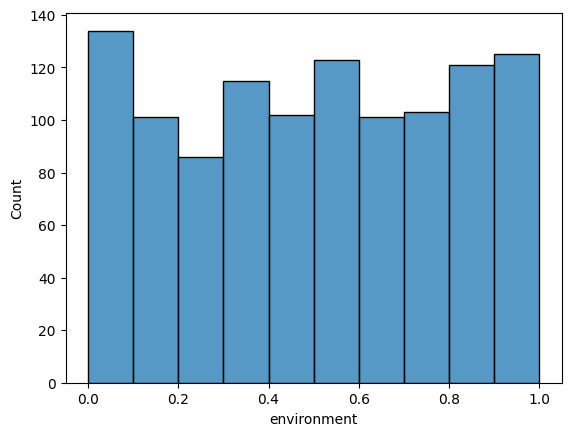

In [71]:
import seaborn as sns
sns.histplot(data=df, x='environment', bins=10)

<AxesSubplot:xlabel='social', ylabel='Count'>

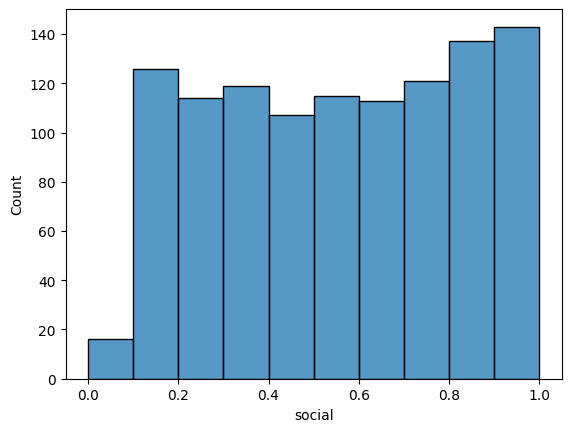

In [72]:
sns.histplot(data=df, x='social', bins=10)

<AxesSubplot:xlabel='governance', ylabel='Count'>

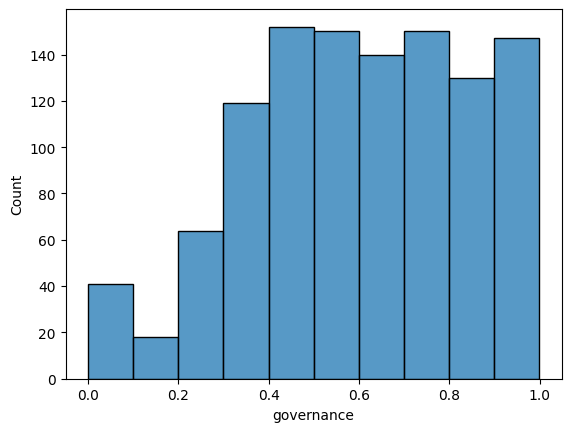

In [73]:
sns.histplot(data=df, x='governance', bins=10)

# ANN: Drie outputs

In [78]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.Sequential([
    # Add a fully connected layer with 64 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),
    # Add a fully connected layer with 32 units and ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),
    # Add a fully connected layer with 3 units and sigmoid activation
    tf.keras.layers.Dense(3, activation='sigmoid')
])

# Compile the model with a mean squared error loss function and an Adam optimizer
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


In [79]:
# Define the input and output data
X = df.drop(['general_score', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df[['environment','social','governance']]

# Train the model
model.fit(X, y, epochs=20)

Epoch 1/20
35/35 [==============================] - 0s 997us/step - loss: 0.3194 - accuracy: 0.3438
Epoch 2/20
35/35 [==============================] - 0s 939us/step - loss: 0.3194 - accuracy: 0.3438
Epoch 3/20
35/35 [==============================] - 0s 880us/step - loss: 0.3194 - accuracy: 0.3438
Epoch 4/20
35/35 [==============================] - 0s 792us/step - loss: 0.3194 - accuracy: 0.3438
Epoch 5/20
35/35 [==============================] - 0s 1ms/step - loss: 0.3194 - accuracy: 0.3438
Epoch 6/20
35/35 [==============================] - 0s 909us/step - loss: 0.3194 - accuracy: 0.3438
Epoch 7/20
35/35 [==============================] - 0s 939us/step - loss: 0.3194 - accuracy: 0.3438
Epoch 8/20
35/35 [==============================] - 0s 880us/step - loss: 0.3194 - accuracy: 0.3438
Epoch 9/20
35/35 [==============================] - 0s 2ms/step - loss: 0.3194 - accuracy: 0.3438
Epoch 10/20
35/35 [==============================] - 0s 880us/step - loss: 0.3194 - accuracy: 0.3438
Epo

In [91]:
y_pred = model.predict(X_test[:-1])
print(y_pred[0][0])

9/9 [==============================] - 0s 747us/step
1.0


# ANN: General Score berekenen

In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general_score', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['general_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')


Test loss: 0.30780160427093506


In [21]:
from keras.models import load_model
model.save('ann-general-score.h5')
ann = load_model('ann-general-score.h5')

In [22]:
new_data = np.array([[15695287, 22250545, 9, 1, 1.320000]])
new_data = scaler.transform(new_data)
prediction = ann.predict(new_data)
print(prediction)

1/1 [==============================] - 0s 43ms/step
[[-846871.2]]


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# E berekenen

In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general_score', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['environment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')

Test loss: 0.09066100418567657


In [24]:
from keras.models import load_model
model.save('ann-environment-score.h5')
ann = load_model('ann-environment-score.h5')

In [25]:
new_data = np.array([[15695287, 22250545, 38.498630, 100,  1.320000]])
new_data = scaler.transform(new_data)
prediction = ann.predict(new_data)
print(prediction)

1/1 [==============================] - 0s 36ms/step
[[-604054.7]]


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# S berekenen

In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general_score', 'domein_environment','domein_social','domein_governance', 'ondernemingsnummer'], axis=1)
y = df['domein_social']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')

KeyError: "['domein_environment', 'domein_social', 'domein_governance'] not found in axis"

In [ ]:
from keras.models import load_model
model.save('ann-social-score.h5')
ann = load_model('ann-social-score.h5')

In [ ]:
new_data = np.array([[15695287, 22250545, 38.498630, 100, 1, 1.320000]])
new_data = scaler.transform(new_data)
prediction = ann.predict(new_data)
print(prediction)

1/1 [==============================] - 0s 34ms/step
[[0.68925333]]


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# G berekenen

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general_score', 'domein_environment','domein_social','domein_governance', 'ondernemingsnummer'], axis=1)
y = df['domein_governance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')

Test loss: 0.057135872542858124


In [ ]:
from keras.models import load_model
model.save('ann-governance-score.h5')
ann = load_model('ann-governance-score.h5')